# Plot & Scrap

In [29]:
#Library import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')

from os import path
from PIL import Image
import os

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from gensim.corpora.dictionary import Dictionary

import spacy

from collections import Counter

import time
import re
import sys
import requests
from pathlib import Path

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Scraper

In [30]:
def scraper(asin, pages=10):
    
    df = pd.DataFrame(columns=['rating', 'content'])
    pages = range(1,pages+1)
    asin=asin
    
    for page in pages:
        
        print('Scraped {} page(s). Scraping page {}. Total reviews: {}'.format(page-1, page, len(df)))
        
        # iterable url
        url = 'https://www.amazon.com/product-reviews/{}/ref=cm_cr_getr_d_paging_btm_prev_1?pageNumber={}'.format(asin, page)
        
        # getting soup
        driver = webdriver.Chrome()
        driver.get(url)
        time.sleep(1)
        page_source = driver.page_source
        driver.quit()
        soup = BeautifulSoup(page_source,'lxml')
        
        # parsing soup
        reviews = soup.findAll("div", {"class":"a-section review aok-relative"})
        ## parsing reviews section
        reviews = BeautifulSoup('<br/>'.join([str(tag) for tag in reviews]), 'html.parser')
        
        #getting content
        contents = reviews.find_all("span", {"data-hook":"review-body"})
        content_lst = []
        for content in contents:
            text_ = content.find_all("span")[0].get_text("\n").strip()
            text_ = ". ".join(text_.splitlines())
            text_ = re.sub(' +', ' ', text_)
            content_lst.append(text_)
            
        #getting rating
        ratings = reviews.find_all("i", {"data-hook":"review-star-rating"})
        full_rating_lst = []
        for rating in ratings:
            full_rating_lst.append(rating.find_all("span")[0].contents[0])
            
        
        rating_lst = []
        for rating in full_rating_lst:
            rating_lst.append(re.findall("\d+\.\d+", rating)[0])
            
            
        # concatenating to main data frame
        
        temp_df = pd.DataFrame({'rating':rating_lst, 'content':content_lst})
        df = df.append(temp_df)
        
    return df


## Plotter

In [31]:
# wordcloud function

def plot_wordclouds_scrapper_bigram(product_reviews):
    
    # Getting text polarity and subjectivity
    product_reviews['polarity'] = [TextBlob(review).sentiment.polarity for review in product_reviews['content'].tolist()]
    product_reviews['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in product_reviews['content'].tolist()]
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['content']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    # plotting output
    figure, axis = plt.subplots(2, 2, figsize=(20,15))
    title_font_size = 25
    sns.set_theme(style="whitegrid")
    
    #Plotting star review
    total_reviews = pd.DataFrame(product_reviews.groupby(product_reviews['rating'])['content'].agg('count'))
    labels = total_reviews.index.to_list()
    data = total_reviews['content']
    
    plt.figure(figsize=(15,8))
    colors = sns.color_palette('pastel')[0:5]
    axis[0,0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axis[0,0].set_title("Number of reviews by star score", fontsize=title_font_size)
    axis[0,0].legend()    
    
    #plotting overall sentiment
    pol_sub = pd.DataFrame({'Name':['Comment positivity', 'Comment subjectivity'], 'Values':[np.median(product_reviews.polarity), np.median(product_reviews.subjectivity)]})
    
    sns.set_color_codes("pastel")
    sns.barplot(x="Values", y="Name", data=pol_sub, label="Total", color="b", ax=axis[0,1])
    axis[0,1].set_xticks([-1,0,1])
    axis[0,1].set_xticklabels(['Low','Neutral','High'])
    axis[0,1].set(xlim=(-1, 1), ylabel="",xlabel="")
    axis[0,1].set_title("Overall review sentiment & subjectiveness", fontsize=title_font_size)
    sns.despine(left=True, bottom=True)
    
    
    ######## plotting negative reviews cloud
    
    #getting negative reviews
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))]
    negative_reviews_string = str([i for i in negative_reviews['content']])
    
    negative_blob = TextBlob(negative_reviews_string)
    NounPhrases = negative_blob.noun_phrases
    # Creating an empty list to hold new values
    # combining the noun phrases using underscore to visualize it as wordcloud
    NewNounList=[]
    for words in NounPhrases:
        NewNounList.append(words.replace(" ", "_"))
        
    # Converting list into a string to plot wordcloud
    NegativeNewNounString=' '.join(NewNounList)
    negative_cloud = WordCloud(stopwords=my_stop_words, background_color='white', colormap='Reds').generate(NegativeNewNounString)
    
    ######## plotting positive reviews cloud
    
    #
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))]
    positive_reviews_string = str([i for i in positive_reviews['content']])
    
    positive_blob = TextBlob(positive_reviews_string)
    NounPhrases = positive_blob.noun_phrases
    # Creating an empty list to hold new values
    # combining the noun phrases using underscore to visualize it as wordcloud
    NewNounList=[]
    for words in NounPhrases:
        NewNounList.append(words.replace(" ", "_"))
        
    # Converting list into a string to plot wordcloud
    PositiveNewNounString=' '.join(NewNounList)
    
    positive_cloud = WordCloud(stopwords=my_stop_words, background_color='white', colormap='Greens_r').generate(PositiveNewNounString)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=title_font_size)
    axis[1,0].imshow(negative_cloud, interpolation='bilinear')
    axis[1,0].axis("off")
    
    # Plot positive wordcloud
    axis[1,1].set_title("What positive reviews talk about...", fontsize=title_font_size)
    axis[1,1].imshow(positive_cloud, interpolation='bilinear') 
    axis[1,1].axis("off")
    
    plt.show()

## Plot & Scrap

In [32]:
def plot_and_scrap(asin,pages):
    df = scraper(asin, pages)
    plot_wordclouds_scrapper_bigram(df)

Scraped 0 page(s). Scraping page 1. Total reviews: 0
Scraped 1 page(s). Scraping page 2. Total reviews: 10
Scraped 2 page(s). Scraping page 3. Total reviews: 20


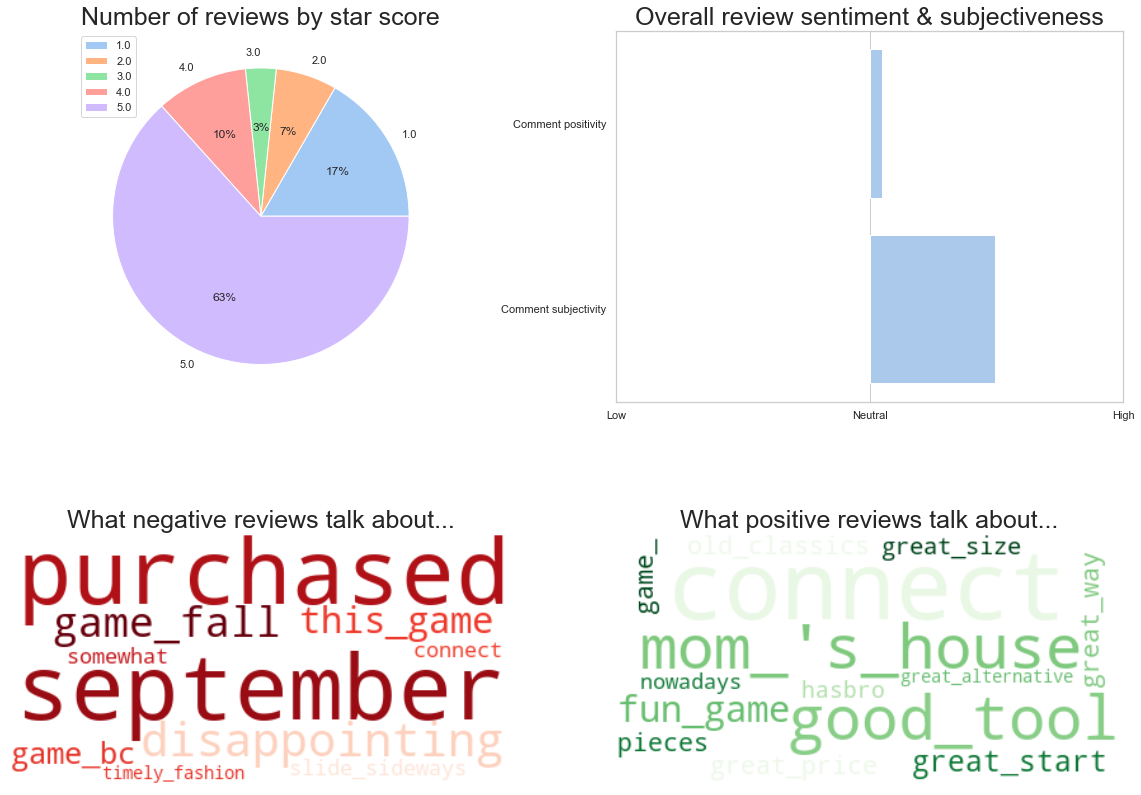

<Figure size 1080x576 with 0 Axes>

In [34]:
plot_and_scrap('B00D8STBHY',3)